# Import related libraries

In [1]:
from scipy.sparse import csr_matrix
import pandas as pd
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import re
import os


# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Download the dataset

In [2]:
DATASET_URL = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
ZIP_PATH = "ml-32m.zip"
DATASET_DIR = "ml-32m" 
EXTRACTED_FOLDER = os.path.join(DATASET_DIR, "ml-latest") 


if not os.path.exists(ZIP_PATH):
    print(f"Downloading {DATASET_URL}...")
    import requests
    response = requests.get(DATASET_URL, stream=True)
    with open(ZIP_PATH, "wb") as handle:
        for data in response.iter_content(chunk_size=8192):
            handle.write(data)
    print("Download complete.")
else:
    print(f"{ZIP_PATH} already exists.")

# Unzip the dataset
if not os.path.exists(EXTRACTED_FOLDER):
    print(f"Extracting {ZIP_PATH}...")
    with ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    # The zip file extracts into 'ml-latest', let's adjust DATA_DIR if needed or use EXTRACTED_FOLDER
    if os.path.exists(os.path.join(DATASET_DIR, "ml-32m")): # Adjust if structure differs
         EXTRACTED_PATH = os.path.join(DATASET_DIR, "ml-32m")
    elif os.path.exists(os.path.join(DATASET_DIR, "ml-latest")):
         EXTRACTED_PATH = os.path.join(DATASET_DIR, "ml-latest") # common case
    else:
         print("Warning: Could not determine exact extracted folder name ('ml-latest' or 'ml-32m'). Check extraction.")
         # Fallback - may need manual adjustment if the below fails
         EXTRACTED_PATH = DATASET_DIR

    print("Extraction complete.")
else:
    print(f"Data directory {EXTRACTED_PATH} already exists.")

Download complete.
Extracting ml-32m.zip...
Extraction complete.


# Loading dataset dataframes

In [3]:
ratings_path = os.path.join(EXTRACTED_PATH, 'ratings.csv')
movies_path = os.path.join(EXTRACTED_PATH, 'movies.csv')
tags_path = os.path.join(EXTRACTED_PATH, 'tags.csv')

print("Loading dataset dataframes started!")

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)

print("Dataset dataframes successfully loaded!")

Loading dataset dataframes started!
Dataset dataframes successfully loaded!


# Dataframes statistics

In [5]:

#  Ratings Dataframe
print('\nRatnings dataframe info:\n')
print(ratings_df.info())

print('\nRatnings dataframe first 5 elements:\n')
print(ratings_df.head())

print("\nNumber of unique users: ", ratings_df['userId'].nunique())
print("Number of unique movies: ", ratings_df['movieId'].nunique())

print("\nStatistics of the ratings of movies:\n")
print(ratings_df['rating'].describe())

#  Movies DataFrame 
print('\nMovies dataframe info:\n')
print(movies_df.info())

print('\nMovies dataframe first 5 elements:\n')
print(movies_df.head())
print("\nNumber of unique movies in metadata: ", movies_df['movieId'].nunique())

#  Tags DataFrame 
print('\nMovies dataframe info:\n')
print(tags_df.info())

print('\nMovies dataframe first 5 elements:\n')
print(tags_df.head())

print("\nNumber of unique tags: ", tags_df['tag'].nunique())
print("Number of unique movies tagged: ", tags_df['movieId'].nunique())
print("Number of unique users who tagged: ", tags_df['userId'].nunique())


Ratnings dataframe info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Ratnings dataframe first 5 elements:

   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Number of unique users:  200948
Number of unique movies:  84432

Statistics of the ratings of movies:

count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Movies dataframe info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 e

# Preprocessing Data

In [6]:
def getyear(movietitle):
    match = re.search(r'\((\d{4})\)$', movietitle.strip())
    if match:
        return int(match.group(1))
    return None 


movies_df['year'] = movies_df['title'].apply(getyear)
movies_df['title_clean'] = movies_df['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)$', '', x).strip())
movies_df['genres_list'] = movies_df['genres'].str.split('|')
movies_df['genres_list'] = movies_df['genres_list'].apply(lambda x: [] if x == ['(no genres listed)'] else x)

print('Movies dataframe after preprocessing: \n')
print(movies_df.head())

Movies dataframe after preprocessing: 

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres    year  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0   
1                   Adventure|Children|Fantasy  1995.0   
2                               Comedy|Romance  1995.0   
3                         Comedy|Drama|Romance  1995.0   
4                                       Comedy  1995.0   

                   title_clean  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                         genres_list  
0  [Adventure, Animation, Children, Comedy, Fantas

In [7]:
# Convert tags to lowercase and trim whitespace
tags_df['tag_clean'] = tags_df['tag'].str.lower().str.strip()

# Handle potential NaN tags if any resulted from cleaning (unlikely but safe)
tags_df.dropna(subset=['tag_clean'], inplace=True)
# Remove empty tags if any resulted from stripping
tags_df = tags_df[tags_df['tag_clean'] != '']


print("Tags DataFrame preprocessing complete.")
print(f"Number of unique tags (cleaned): {tags_df['tag_clean'].nunique()}")
print(tags_df[['userId', 'movieId', 'tag_clean', 'timestamp']].head())

Tags DataFrame preprocessing complete.
Number of unique tags (cleaned): 131644
   userId  movieId    tag_clean   timestamp
0      22    26479  kevin kline  1583038886
1      22    79592     misogyny  1581476297
2      22   247150   acrophobia  1622483469
3      34     2174        music  1249808064
4      34     2174        weird  1249808102


# Objective 2: Analyze Tag-Rating Relationship

In [8]:
# --- 6.1 Calculate Average Rating per Movie --- Objective 2: Analyze Tag-Rating Relationship
print("Calculating average rating per movie...")
movie_avg_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
movie_rating_counts = ratings_df.groupby('movieId')['rating'].count().reset_index().rename(columns={'rating': 'rating_count'})

movie_stats = pd.merge(movie_avg_ratings, movie_rating_counts, on='movieId', how='left')
print(f"Calculated average ratings for {movie_stats['movieId'].nunique()} movies.")
print(movie_stats.head())

# --- 6.2 Merge Tags with Movie Ratings ---
print("Merging tags with average movie ratings...")
tags_with_avg_rating = pd.merge(tags_df, movie_stats[['movieId', 'rating', 'rating_count']], on='movieId', how='inner')
print(f"Merged tags DataFrame shape: {tags_with_avg_rating.shape}")
print(tags_with_avg_rating[['movieId', 'tag_clean', 'rating', 'rating_count']].head())

# --- 6.3 Calculate Average Rating per Tag ---
print("Calculating statistics per tag...")
tag_stats = tags_with_avg_rating.groupby('tag_clean').agg(
    tag_count=('tag_clean', 'size'),
    avg_movie_rating=('rating', 'mean'), # Avg rating of movies bearing this tag
    avg_movie_rating_count = ('rating_count', 'mean') # Avg number of ratings for movies bearing this tag
).reset_index()

print(f"Calculated stats for {tag_stats['tag_clean'].nunique()} unique cleaned tags.")
print(tag_stats.head())

Calculating average rating per movie...
Calculated average ratings for 84432 movies.
   movieId    rating  rating_count
0        1  3.897438         68997
1        2  3.275758         28904
2        3  3.139447         13134
3        4  2.845331          2806
4        5  3.059602         13154
Merging tags with average movie ratings...
Merged tags DataFrame shape: (1982768, 7)
   movieId    tag_clean    rating  rating_count
0    26479  kevin kline  3.468927           177
1    79592     misogyny  3.445169          4833
2   247150   acrophobia  3.005263           285
3     2174        music  3.516450         24681
4     2174        weird  3.516450         24681
Calculating statistics per tag...
Calculated stats for 130689 unique cleaned tags.
                 tag_clean  tag_count  avg_movie_rating  \
0  !950's superman tv show          1          3.045704   
1        !david o. russell          1          3.586487   
2          !george clooney          1          3.586487   
3            

In [16]:
# --- 6.4 Filter and Analyze Frequent Tags ---
MIN_TAG_COUNT = 100 # Set a threshold for tag frequency
print(f"\nFiltering tags with at least {MIN_TAG_COUNT} occurrences...")
frequent_tag_stats = tag_stats[tag_stats['tag_count'] >= MIN_TAG_COUNT].copy()
print(f"Number of frequent tags (>= {MIN_TAG_COUNT} occurrences): {len(frequent_tag_stats)}")

# Sort by average movie rating
frequent_tag_stats_sorted = frequent_tag_stats.sort_values('avg_movie_rating', ascending=False)

# --- 6.5 Results: Top and Bottom Rated Tags ---
N_TOP_BOTTOM = 30
print(f"\n--- Top {N_TOP_BOTTOM} Frequent Tags Associated with Highest Average Movie Ratings ---")
print(frequent_tag_stats_sorted.head(N_TOP_BOTTOM)[['tag_clean', 'avg_movie_rating', 'tag_count']])

print(f"\n--- Top {N_TOP_BOTTOM} Frequent Tags Associated with Lowest Average Movie Ratings ---")
print(frequent_tag_stats_sorted.tail(N_TOP_BOTTOM)[['tag_clean', 'avg_movie_rating', 'tag_count']])


Filtering tags with at least 100 occurrences...
Number of frequent tags (>= 100 occurrences): 2925

--- Top 30 Frequent Tags Associated with Highest Average Movie Ratings ---
                                 tag_clean  avg_movie_rating  tag_count
95812                           relativity          4.116370        171
46986                         good science          4.103919        206
108353                        space action          4.099824        110
71519                             miyazaki          4.099494        102
49906                       hayao miyazaki          4.098436        683
22245                       classic sci-fi          4.087989        222
85387                      powerful ending          4.083286        803
73234             multiple interpretations          4.079992        118
22175                         class themes          4.078605        147
68624                          masterpiece          4.076480        883
47131                   gorgeous

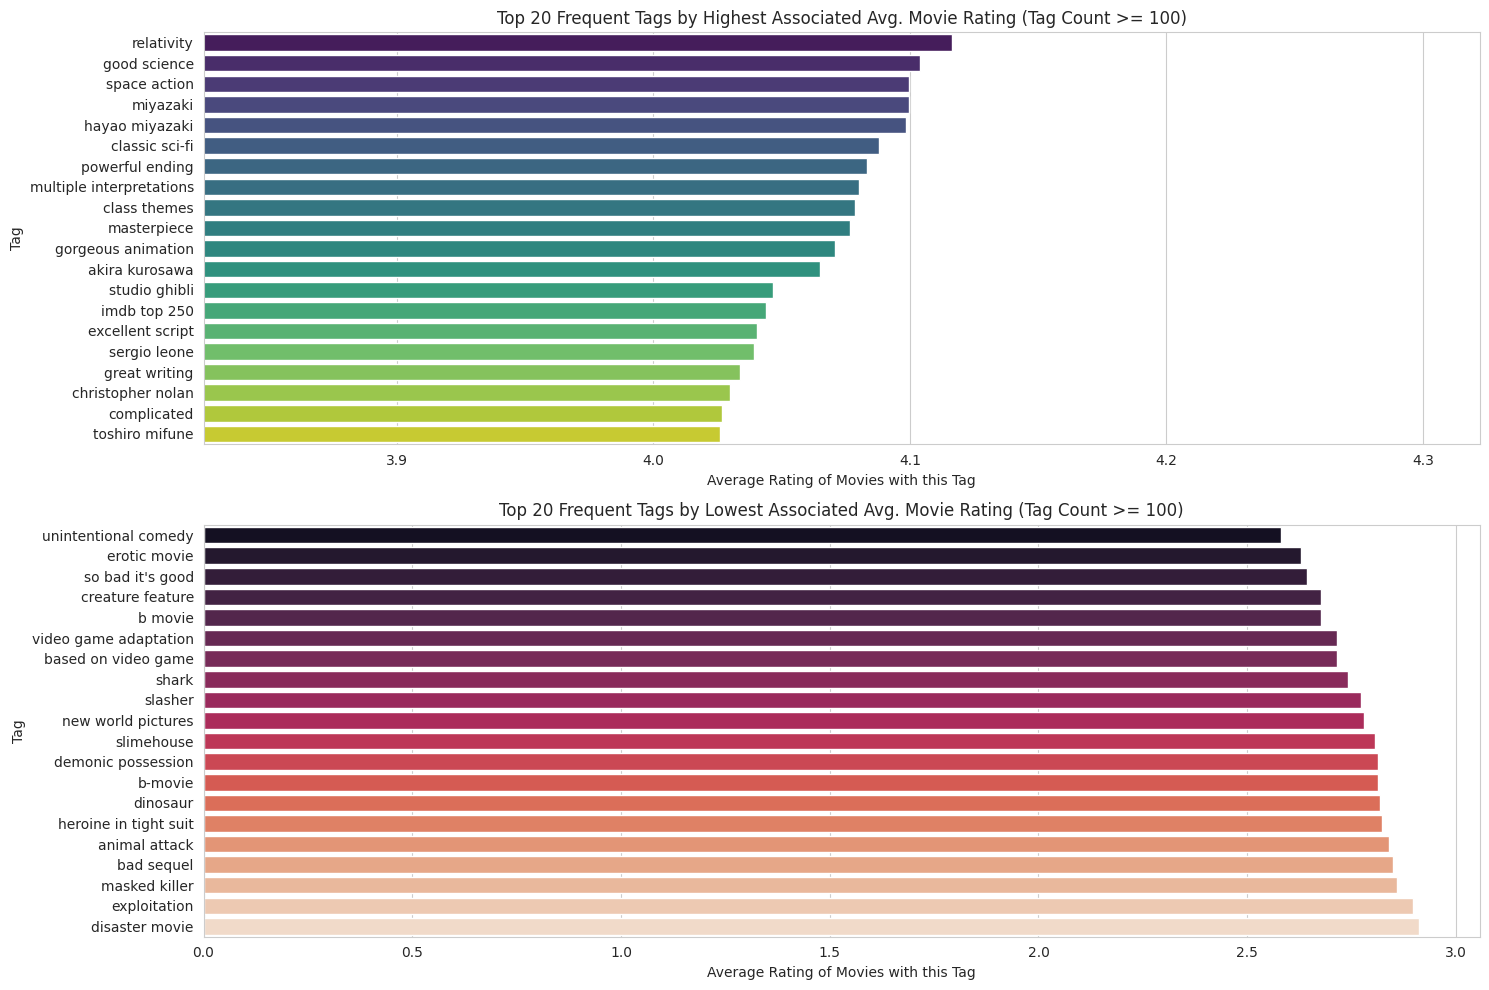

In [10]:
# --- 6.6 Visualization ---
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
top_tags = frequent_tag_stats_sorted.head(N_TOP_BOTTOM)
sns.barplot(x='avg_movie_rating', y='tag_clean', data=top_tags, palette='viridis')
plt.title(f'Top {N_TOP_BOTTOM} Frequent Tags by Highest Associated Avg. Movie Rating (Tag Count >= {MIN_TAG_COUNT})')
plt.xlabel('Average Rating of Movies with this Tag')
plt.ylabel('Tag')
plt.xlim(left=top_tags['avg_movie_rating'].min() * 0.95) # Adjust xlim for better visibility

plt.subplot(2, 1, 2)
bottom_tags = frequent_tag_stats_sorted.tail(N_TOP_BOTTOM).sort_values('avg_movie_rating', ascending=True) # sort ascending for plot
sns.barplot(x='avg_movie_rating', y='tag_clean', data=bottom_tags, palette='rocket')
plt.title(f'Top {N_TOP_BOTTOM} Frequent Tags by Lowest Associated Avg. Movie Rating (Tag Count >= {MIN_TAG_COUNT})')
plt.xlabel('Average Rating of Movies with this Tag')
plt.ylabel('Tag')
plt.xlim(right=bottom_tags['avg_movie_rating'].max() * 1.05) # Adjust xlim

plt.tight_layout()
plt.show()

In [17]:
# @title 7. Objective 3: Analyze Tag-Genre Relationship

print("\n--- Objective 3: Analyzing Tag-Genre Relationship ---")

# --- 7.1 Merge Tags with Movie Genres ---
print("Merging tags with movie genres...")
# Use movies_df which has 'genres_list'
tags_with_genres = pd.merge(tags_df[['movieId', 'tag_clean']],
                            movies_df[['movieId', 'genres_list']],
                            on='movieId',
                            how='inner')

print(f"Merged tags/genres DataFrame shape: {tags_with_genres.shape}")
print(tags_with_genres.head())

# --- 7.2 Explode Genres ---
# Create one row per tag-movie-genre combination
print("Exploding genres list...")
tags_genres_exploded = tags_with_genres.explode('genres_list')
tags_genres_exploded = tags_genres_exploded.rename(columns={'genres_list': 'genre'})

# Drop rows where genre might be NaN or empty if they resulted from the merge/explode
tags_genres_exploded.dropna(subset=['genre'], inplace=True)
tags_genres_exploded = tags_genres_exploded[tags_genres_exploded['genre'] != ''] # Ensure no empty strings

print(f"Exploded DataFrame shape: {tags_genres_exploded.shape}")
print(tags_genres_exploded.head())


--- Objective 3: Analyzing Tag-Genre Relationship ---
Merging tags with movie genres...
Merged tags/genres DataFrame shape: (2000049, 3)
   movieId    tag_clean                            genres_list
0    26479  kevin kline  [Adventure, Comedy, Musical, Romance]
1    79592     misogyny                       [Action, Comedy]
2   247150   acrophobia                        [Drama, Sci-Fi]
3     2174        music                      [Comedy, Fantasy]
4     2174        weird                      [Comedy, Fantasy]
Exploding genres list...
Exploded DataFrame shape: (5073886, 3)
   movieId    tag_clean      genre
0    26479  kevin kline  Adventure
0    26479  kevin kline     Comedy
0    26479  kevin kline    Musical
0    26479  kevin kline    Romance
1    79592     misogyny     Action


In [13]:
# --- 7.3 Calculate Top Tags per Genre ---
print("\nCalculating top tags per genre...")
genre_tag_counts = tags_genres_exploded.groupby(['genre', 'tag_clean']).size().reset_index(name='count')

# Get top N tags for each genre
N_TOP_TAGS_PER_GENRE = 10
top_tags_per_genre = genre_tag_counts.sort_values(['genre', 'count'], ascending=[True, False]) \
                                      .groupby('genre') \
                                      .head(N_TOP_TAGS_PER_GENRE)

print(f"\n--- Top {N_TOP_TAGS_PER_GENRE} Tags for Selected Genres ---")
selected_genres = ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Horror', 'Romance', 'Animation']
for genre in selected_genres:
    if genre in top_tags_per_genre['genre'].unique():
        print(f"\n-- Genre: {genre} --")
        print(top_tags_per_genre[top_tags_per_genre['genre'] == genre][['tag_clean', 'count']])
    else:
        print(f"\n-- Genre: {genre} (No tags found or not in top list) --")


Calculating top tags per genre...

--- Top 10 Tags for Selected Genres ---

-- Genre: Action --
                tag_clean  count
675                action   8394
37530              sci-fi   6996
42098           superhero   3746
13161            dystopia   3311
46502  visually appealing   2988
889             adventure   2638
46391            violence   2385
17127               funny   2257
2939          atmospheric   2219
26418        martial arts   2209

-- Genre: Comedy --
           tag_clean  count
133926        comedy   8360
143208         funny   6551
135868   dark comedy   4379
163140        quirky   3589
128627  black comedy   3031
168693        satire   2748
167808       romance   2711
174496       surreal   1994
125340     animation   1992
143032    friendship   1963

-- Genre: Drama --
                tag_clean  count
235390        atmospheric   6510
300259            surreal   4787
236887    based on a book   4203
302441  thought-provoking   4088
304798       twist ending 

In [18]:
# --- 7.4 Calculate Top Genres per Tag ---
# Focus on frequent tags identified earlier
print(f"\nCalculating top genres for frequent tags (tag count >= {MIN_TAG_COUNT})...")
popular_tags_list = frequent_tag_stats['tag_clean'].tolist()

tag_genre_counts = tags_genres_exploded[tags_genres_exploded['tag_clean'].isin(popular_tags_list)] \
                                        .groupby(['tag_clean', 'genre']).size().reset_index(name='count')

N_TOP_GENRES_PER_TAG = 9
top_genres_per_tag = tag_genre_counts.sort_values(['tag_clean', 'count'], ascending=[True, False]) \
                                      .groupby('tag_clean') \
                                      .head(N_TOP_GENRES_PER_TAG)

print(f"\n--- Top {N_TOP_GENRES_PER_TAG} Genres for Selected Frequent Tags ---")
selected_tags_for_genre_analysis = ['sci-fi', 'funny', 'based on a book', 'dystopian', 'world war ii', 'superhero', 'dark comedy']
for tag in selected_tags_for_genre_analysis:
    if tag in top_genres_per_tag['tag_clean'].unique():
        print(f"\n-- Tag: {tag} --")
        print(top_genres_per_tag[top_genres_per_tag['tag_clean'] == tag][['genre', 'count']])
    else:
         print(f"\n-- Tag: {tag} (Not frequent enough or no genre data) --")



Calculating top genres for frequent tags (tag count >= 100)...

--- Top 9 Genres for Selected Frequent Tags ---

-- Tag: sci-fi --
           genre  count
36856     Sci-Fi  11166
36841     Action   6996
36857   Thriller   4787
36842  Adventure   4747
36848      Drama   2929
36852       IMAX   1942
36854    Mystery   1371
36851     Horror   1002
36845     Comedy    826

-- Tag: funny --
           genre  count
17293     Comedy   6551
17289     Action   2257
17290  Adventure   2178
17296      Drama   2001
17303    Romance   1584
17292   Children   1318
17291  Animation   1301
17294      Crime   1239
17297    Fantasy   1145

-- Tag: based on a book --
          genre  count
4156      Drama   4203
4150  Adventure   1927
4165   Thriller   1708
4157    Fantasy   1402
4163    Romance   1239
4149     Action   1176
4154      Crime   1115
4164     Sci-Fi   1111
4153     Comedy   1007

-- Tag: dystopian --
           genre  count
13443     Sci-Fi    328
13444   Thriller    256
13429     Action  

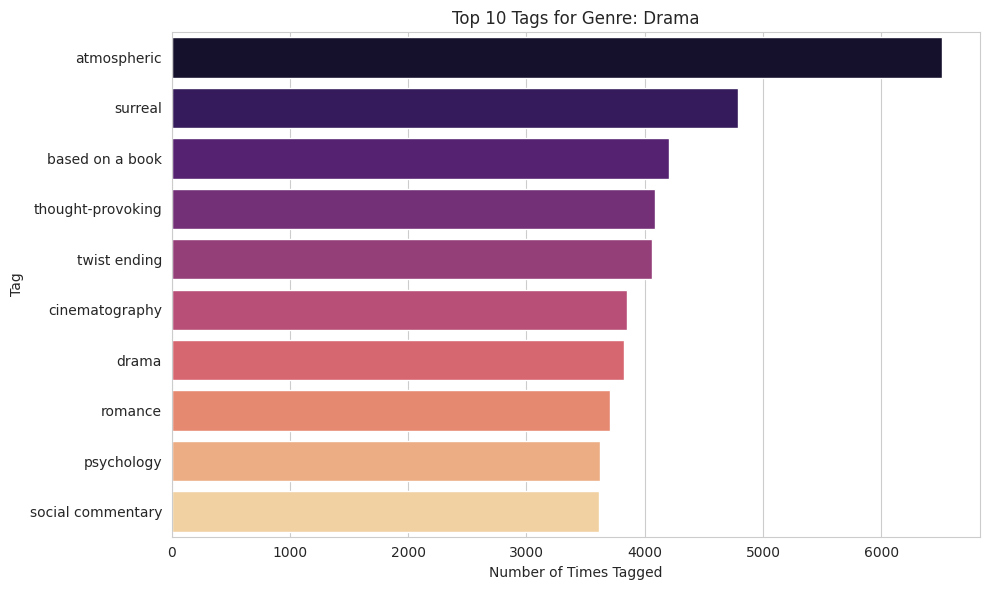

In [20]:
# --- 7.5 Visualization (Example: Top Tags for Action) ---
genre_to_plot = 'Drama'
if genre_to_plot in top_tags_per_genre['genre'].unique():
    plt.figure(figsize=(10, 6))
    action_top_tags = top_tags_per_genre[top_tags_per_genre['genre'] == genre_to_plot]
    sns.barplot(x='count', y='tag_clean', data=action_top_tags, palette='magma')
    plt.title(f'Top {N_TOP_TAGS_PER_GENRE} Tags for Genre: {genre_to_plot}')
    plt.xlabel('Number of Times Tagged')
    plt.ylabel('Tag')
    plt.tight_layout()
    plt.show()

In [21]:
# Get unique user and movie IDs that appear in ratings
unique_user_ids = ratings_df['userId'].unique()
unique_movie_ids = ratings_df['movieId'].unique()

# Create the mapping dictionaries
user_id_to_matrix_idx = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
movie_id_to_matrix_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}

# Create reverse mappings (matrix index to original ID) - useful for interpretation later
matrix_idx_to_user_id = {idx: user_id for user_id, idx in user_id_to_matrix_idx.items()}
matrix_idx_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_matrix_idx.items()}

# Map the ratings DataFrame to matrix indices
ratings_df['user_matrix_idx'] = ratings_df['userId'].map(user_id_to_matrix_idx)
ratings_df['movie_matrix_idx'] = ratings_df['movieId'].map(movie_id_to_matrix_idx)

print(f"Mapped {len(unique_user_ids)} users and {len(unique_movie_ids)} movies to matrix indices.")

Mapped 200948 users and 84432 movies to matrix indices.


In [22]:
print("Creating sparse User-Item matrix (CSR format)...")

# Get the data, row indices, and column indices for the sparse matrix
ratings_data = ratings_df['rating'].values
row_indices = ratings_df['user_matrix_idx'].values
col_indices = ratings_df['movie_matrix_idx'].values

# Define the shape of the matrix
n_users = len(unique_user_ids)
n_movies = len(unique_movie_ids)
matrix_shape = (n_users, n_movies)

try:
    # Create the CSR matrix
    user_item_sparse = csr_matrix((ratings_data, (row_indices, col_indices)), shape=matrix_shape)
    print("Sparse matrix created successfully.")
    print(f"Sparse User-Item Matrix shape: {user_item_sparse.shape}")
    print(f"Number of stored elements (ratings): {user_item_sparse.nnz}") # nnz = number of non-zero elements
except Exception as e:
    print(f"Error creating sparse matrix: {e}")
    raise

Creating sparse User-Item matrix (CSR format)...
Sparse matrix created successfully.
Sparse User-Item Matrix shape: (200948, 84432)
Number of stored elements (ratings): 32000204


In [23]:
print("Calculating item-item cosine similarity on the transpose of the sparse matrix...")
try:
    item_similarity_sparse = cosine_similarity(user_item_sparse.T, dense_output=False) # Keep it sparse if possible
    print("Item similarity sparse matrix calculated.")
    print(f"Item similarity matrix shape: {item_similarity_sparse.shape}")
    # Note: item_similarity_sparse is (n_movies x n_movies)
except MemoryError:
     print("MemoryError during cosine similarity calculation, even with sparse input.")
     print("The item-item similarity matrix itself might be too large as a dense matrix.")
     print("Trying with dense_output=False (if not already done). If this still fails, consider sampling or alternative methods.")
     # As a fallback, try forcing dense output if sparse failed for some reason, but expect potential crash:
     # item_similarity = cosine_similarity(user_item_sparse.T, dense_output=True)
     # item_sim_df = pd.DataFrame(item_similarity, index=unique_movie_ids, columns=unique_movie_ids) # Map back later if needed
     raise
except Exception as e:
    print(f"Error calculating item similarity: {e}")
    raise

Calculating item-item cosine similarity on the transpose of the sparse matrix...
Item similarity sparse matrix calculated.
Item similarity matrix shape: (84432, 84432)


In [26]:
# --- 8.4 Implement Recommendation Function (Using Sparse Matrix) ---
def get_item_based_recommendations_sparse(user_id, num_recs=10):
    """Generates movie recommendations for a user using item-based CF with sparse matrices."""

    # --- Check if user exists and get matrix index ---
    if user_id not in user_id_to_matrix_idx:
        print(f"User ID {user_id} not found in the rating data.")
        return pd.DataFrame() # Return empty DataFrame
    user_matrix_idx = user_id_to_matrix_idx[user_id]

    # --- Get movies the user HAS rated (from sparse matrix) ---
    # Get the row corresponding to the user
    user_row = user_item_sparse[user_matrix_idx, :]
    # .indices gives the column indices (movie matrix indices) of non-zero elements
    rated_movie_matrix_indices = user_row.indices
    # .data gives the corresponding non-zero values (ratings)
    user_ratings_data = user_row.data

    # Create a dictionary mapping movie_matrix_idx to rating for this user
    user_ratings_dict = dict(zip(rated_movie_matrix_indices, user_ratings_data))

    # --- Identify movies the user HAS NOT rated ---
    all_movie_matrix_indices = set(range(n_movies))
    unrated_movie_matrix_indices = all_movie_matrix_indices - set(rated_movie_matrix_indices)

    # --- Calculate predicted ratings for unrated movies ---
    predictions = {}
    for movie_matrix_idx in unrated_movie_matrix_indices:
        # Get similarities between this movie and all *other* movies
        # item_similarity_sparse is (movie_idx, movie_idx)
        # Get the row for the current movie_matrix_idx
        similarities_row = item_similarity_sparse[movie_matrix_idx, :]

        # We only care about similarities to movies the user *has* rated
        # Get similarities only for columns corresponding to rated_movie_matrix_indices
        sims_to_rated_items = similarities_row[:, rated_movie_matrix_indices]

        # Get the actual ratings the user gave to these rated items
        ratings_of_rated_items = np.array([user_ratings_dict[idx] for idx in rated_movie_matrix_indices])

        # Perform the dot product for weighted sum: sims * ratings
        # sims_to_rated_items is 1 x N_rated
        # ratings_of_rated_items needs to be N_rated x 1 or similar for dot product
        # Easier: element-wise multiplication then sum
        numerator = (sims_to_rated_items.multiply(ratings_of_rated_items)).sum()

        # Sum of similarities (weights)
        # Need absolute values? Cosine sim can be negative, usually clip at 0 for this type of CF.
        # Let's use sum of positive similarities for denominator.
        denominator = sims_to_rated_items[sims_to_rated_items > 0].sum() # Sum of positive similarities

        if denominator > 0 and numerator > 0: # Ensure meaningful prediction
            predicted_rating = numerator / denominator
            predictions[movie_matrix_idx] = predicted_rating

    # --- Sort predictions and get top N ---
    sorted_predictions = sorted(predictions.items(), key=lambda item: item[1], reverse=True)
    top_recs_matrix_indices = [rec[0] for rec in sorted_predictions[:num_recs]]
    top_recs_scores = {rec[0]: rec[1] for rec in sorted_predictions[:num_recs]}

    # --- Map back to original movie IDs and get details ---
    rec_movie_ids = [matrix_idx_to_movie_id[idx] for idx in top_recs_matrix_indices]

    if not rec_movie_ids:
        print(f"Could not generate recommendations for User {user_id}.")
        return pd.DataFrame()

    rec_details = movies_df[movies_df['movieId'].isin(rec_movie_ids)][['movieId', 'title_clean', 'genres']].copy()
    rec_details['predicted_rating'] = rec_details['movieId'].map(lambda x: top_recs_scores.get(movie_id_to_matrix_idx[x], 0))

    # Ensure order matches prediction sort order by using matrix index scores
    rec_details = rec_details.set_index('movieId')
    # Reindex based on the original sorted list of movie IDs
    rec_details = rec_details.loc[rec_movie_ids].reset_index()


    return rec_details


# --- 8.5 Intuitive Evaluation (Using the new sparse function) ---
print("\n--- Recommender Evaluation (Intuitive Examples using Sparse CF) ---")
SAMPLE_USER_ID_1 = 90 # Choose a user ID from the dataset
SAMPLE_USER_ID_2 = 140 # Choose another user ID

# Function to show user's top rated movies (no change needed here)
def show_user_top_movies(user_id, n=10):
    # Check user exists in original ratings df
    if user_id not in ratings_df['userId'].unique():
         print(f"User ID {user_id} not found.")
         return

    user_rated = ratings_df[ratings_df['userId'] == user_id].sort_values('rating', ascending=False)
    # Ensure merge happens correctly - merge movies_df which has titles
    user_rated = pd.merge(user_rated, movies_df[['movieId', 'title_clean', 'genres']], on='movieId', how='left')
    print(f"\nTop {n} rated movies by User {user_id}:")
    # Display columns from merged df
    print(user_rated[['title_clean', 'genres', 'rating']].head(n).to_string())




--- Recommender Evaluation (Intuitive Examples using Sparse CF) ---


In [27]:
# --- Example 1 ---
show_user_top_movies(SAMPLE_USER_ID_1)
print(f"\nGenerating recommendations for User {SAMPLE_USER_ID_1}...")
recs1 = get_item_based_recommendations_sparse(SAMPLE_USER_ID_1, num_recs=10)
print(f"\nTop 10 Recommendations for User {SAMPLE_USER_ID_1}:")
print(recs1.to_string())

# --- Example 2 ---
show_user_top_movies(SAMPLE_USER_ID_2)
print(f"\nGenerating recommendations for User {SAMPLE_USER_ID_2}...")
recs2 = get_item_based_recommendations_sparse(SAMPLE_USER_ID_2, num_recs=10)
print(f"\nTop 10 Recommendations for User {SAMPLE_USER_ID_2}:")
print(recs2.to_string())


Top 10 rated movies by User 90:
                           title_clean                                           genres  rating
0                      Sixteen Candles                                   Comedy|Romance     5.0
1                  Breakfast Club, The                                     Comedy|Drama     5.0
2               League of Their Own, A                                     Comedy|Drama     5.0
3                      St. Elmo's Fire                                    Drama|Romance     5.0
4                 Beauty and the Beast  Animation|Children|Fantasy|Musical|Romance|IMAX     4.0
5                    Keeping the Faith                             Comedy|Drama|Romance     4.0
6                  Princess Bride, The          Action|Adventure|Comedy|Fantasy|Romance     4.0
7                           Goodfellas                                      Crime|Drama     4.0
8                                  Big                     Comedy|Drama|Fantasy|Romance     4.0
9  Ghos